# Project : Undersampled MRI Reconstruction

**Importing Dependencies**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Writing Basic Functions**

This function converts data from image domain to frequency domain (Image to Kspace)

In [2]:
def citf(image):
    tmp = np.fft.fftshift(cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT))
    complex_matrix = tmp[:,:,0] + 1j * tmp[:,:,1]
    return complex_matrix


This function converts data from frequency domain to Image domain (Kspace to Image)

In [3]:
def cfti(kspace):
    img_inverse = np.flipud(np.fliplr(np.abs(np.fft.ifft2(kspace))))
    return img_inverse

This function takes kspace as input and displays the data in both the image and frequency domain

In [4]:
def show_both(kspace):
    mag_spe = 20*np.log(np.abs(kspace))
    plt.subplot(121), plt.imshow(cfti(kspace), cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(mag_spe, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

This function takes two kspace data and display their images

In [5]:
def diff(t_kspace , u_kspace):
    plt.subplot(121), plt.imshow(cfti(t_kspace), cmap='gray')
    plt.title('Ground Truth'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(cfti(u_kspace), cmap='gray')
    plt.title('Undersampled Image'), plt.xticks([]), plt.yticks([])
    plt.show()

# Data Collection

This part we read the data from the kaggle dataset and store in an numpy array so that we can work on it

In [6]:
images = []
def process_file(file_path):
    if "mask" in file_path or "README" in file_path or ".csv" in file_path:
        time.sleep(0)
    else:
        image = cv2.imread(file_path,0)
        image = np.array(image)
        image = image.astype('float32') / 255.0
        images.append(image)
        return
for folder_name, subfolders, filenames in os.walk("/kaggle/input/lgg-mri-segmentation/kaggle_3m"):
    for filename in filenames:
        if "mask" not in filename:
            file_path = os.path.join(folder_name, filename)
            process_file(file_path)
images = np.asarray(images)

# Data preprocessing

Since we want to undersample our data therefore we need to convert our data from image to frequency domain

In [7]:
kspaces = []
for image in images:
    kspace = citf(image)
    kspaces.append(np.array(kspace))
kspaces = np.asarray(kspaces)

# Undersampling the kspace data

Now we need to undersample our data.

**For this we need to undersample our data in such a way which will decrease the acquisition time and also it is feasible to collect that undersampled data from MRI machine**

Therefore we have chosen an cartesian undersampling.

Preparing mask to undersample the kspace data.

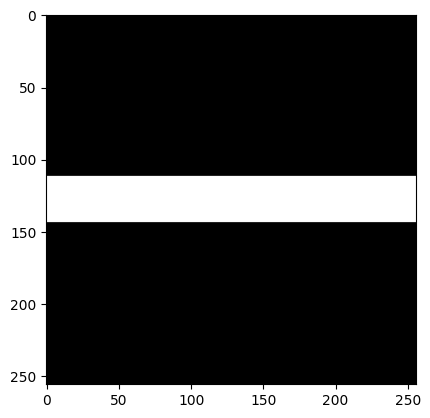

In [8]:
mask = np.zeros((256,256))
mask[112:144,:] = np.ones((32,256))
plt.imshow(mask, cmap='gray')

In [9]:
def unsample_data(data, mask):
    u_kspaces = []
    u_images = []
    for i in range(kspaces.shape[0]):
        u_kspace = np.multiply(kspaces[i,:,:], mask)
        u_kspaces.append(u_kspace)
        u_images.append(cfti(u_kspace))
    return np.array(u_kspaces) , np.array(u_images)

In [10]:
u_kspaces , u_images = unsample_data(kspaces,mask)

At this stage we have preprocessed the data and we have fullysampled kspaces , their corresponding images , undersampled kspaces and their corresponding images.

**We will store this in a file so that we don't require to do this much processing again and again. We will directly read this data from this file if we want to use it again.**

In [11]:
np.savez('data.npz',kspaces=kspaces , u_kspaces = u_kspaces , images=images , u_images=u_images)

In [12]:
# import numpy as np
# data = np.load('data.npz')
# kspaces = data['kspaces']
# u_kspaces = data['u_kspaces']
# images = data['images']
# u_images = data['u_images']

**This example shows the undersampled kspace and its corresponding image**

**You can notice that the image is blurred and most of the fine details of the MRI images are gone**

/tmp/ipykernel_47/3086757226.py:2: RuntimeWarning: divide by zero encountered in log
  mag_spe = 20*np.log(np.abs(kspace))


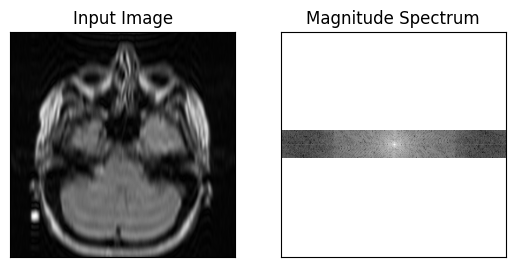

In [13]:
show_both(u_kspaces[100,:,:])

**Comparison between Fullysampled MRI image and Undersampled MRI image**

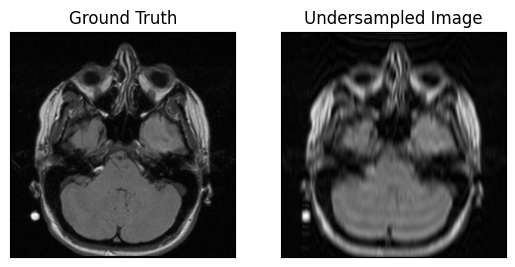

In [14]:
diff(kspaces[100,:,:],u_kspaces[100,:,:])

# Spliting the Data into train and test data

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(u_images , images , test_size=0.2, random_state=42)

# Creating a model architechture

This model is being inspired from the **ReconResNet: Regularised Residual Learning for MR Image Reconstruction of Undersampled Cartesian and Radial Data**

Link of the paper : https://arxiv.org/pdf/2103.09203.pdf

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def res_block(x, filters, kernel_size=3, stride=1, padding='same'):
    """Residual block."""
    res = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, res])
    x = layers.Activation('relu')(x)
    return x

def ResNet(input_shape, num_residual_blocks):
    """Builds the ResNet."""
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Input Down-sampling
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Residual Blocks
    for _ in range(num_residual_blocks):
        x = res_block(x, 64)
    
    # Output Up-sampling
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Final Convolution Layer
    outputs = layers.Conv2D(1, (7, 7), strides=1, padding='same', activation='sigmoid')(x)
    
    # Define the model
    model = models.Model(inputs, outputs)
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=ssim_loss)
    
    return model

# Set input shape and number of residual blocks based on the paper
input_shape = (256,256, 1)  # Assuming grayscale MRI images with variable size
num_residual_blocks = 34

# Create the model
model = ResNet(input_shape, num_residual_blocks)

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 64, 64, 64)           36928     ['conv2d_1[0][0]']            
                                                                                              

# Training the model

In [17]:
model.fit(X_train,Y_train, validation_split=0.2, epochs=25)

Epoch 1/25
79/79 [==============================] - 103s 570ms/step - loss: 0.3133 - val_loss: 0.8356
Epoch 2/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0883 - val_loss: 0.5642
Epoch 3/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0687 - val_loss: 0.6016
Epoch 4/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0619 - val_loss: 0.4851
Epoch 5/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0566 - val_loss: 0.3591
Epoch 6/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0538 - val_loss: 0.2452
Epoch 7/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0607 - val_loss: 0.0815
Epoch 8/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0551 - val_loss: 0.1060
Epoch 9/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0466 - val_loss: 0.0431
Epoch 10/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0463 - val_l

In [18]:
model.save_weights('model25.h5')

In [19]:
a = model.history.history['val_loss']
b = model.history.history['loss']
print(a)
print(b)

[0.8356199264526367, 0.5641877055168152, 0.6016423106193542, 0.48512566089630127, 0.35910171270370483, 0.24520568549633026, 0.08153491467237473, 0.10601592808961868, 0.04310335963964462, 0.0912817120552063, 0.05690145492553711, 0.10146375745534897, 0.05845137685537338, 0.07905759662389755, 0.06355247646570206, 0.04433474317193031, 0.055187005549669266, 0.04170402139425278, 0.0544460229575634, 0.07800037413835526, 0.038452330976724625, 0.08757983893156052, 0.6155474781990051, 0.37247195839881897, 0.06308800727128983]
[0.3133298456668854, 0.08833229541778564, 0.06865601986646652, 0.061945099383592606, 0.05656399205327034, 0.05375466123223305, 0.06073148548603058, 0.05507098510861397, 0.04660085588693619, 0.046304117888212204, 0.051225729286670685, 0.044761620461940765, 0.04582807794213295, 0.0432412251830101, 0.043990086764097214, 0.04562243074178696, 0.0439504012465477, 0.04444479942321777, 0.042751383036375046, 0.04481939226388931, 0.03997969999909401, 0.04140312224626541, 0.0549040772

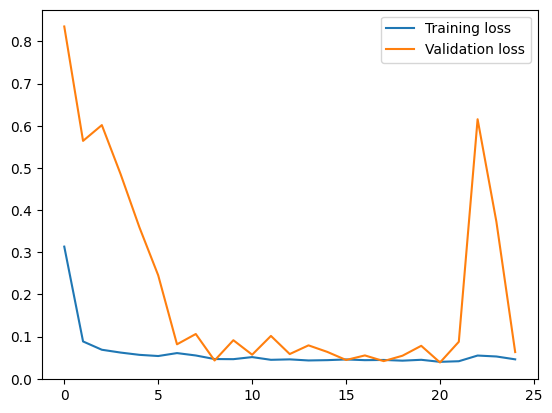

In [20]:
plt.plot(b , label="Training loss")
plt.plot(a , label="Validation loss")
plt.legend()
plt.show()

In [21]:
model.fit(X_train,Y_train, validation_split=0.2, epochs=25)

Epoch 1/25
79/79 [==============================] - 40s 505ms/step - loss: 0.0431 - val_loss: 0.1081
Epoch 2/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0407 - val_loss: 0.0704
Epoch 3/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0393 - val_loss: 0.0538
Epoch 4/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0409 - val_loss: 0.0453
Epoch 5/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0414 - val_loss: 0.0362
Epoch 6/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0479 - val_loss: 0.2262
Epoch 7/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0423 - val_loss: 0.1246
Epoch 8/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0430 - val_loss: 0.0648
Epoch 9/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0392 - val_loss: 0.0431
Epoch 10/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0401 - val_lo

In [22]:
model.save_weights('model50.h5')

In [23]:
a = model.history.history['val_loss']
b = model.history.history['loss']
print(a)
print(b)

[0.10813822597265244, 0.07044921070337296, 0.05377911031246185, 0.045321717858314514, 0.03615695983171463, 0.22624412178993225, 0.12456334382295609, 0.06484971195459366, 0.04314005374908447, 0.07576945424079895, 0.06631350517272949, 0.040242671966552734, 0.06934702396392822, 0.04694913327693939, 0.03974241390824318, 0.03555140271782875, 0.046676382422447205, 0.041106898337602615, 0.04945400729775429, 0.08266667276620865, 0.03659854456782341, 0.053691692650318146, 0.04587489739060402, 0.052831828594207764, 0.052923429757356644]
[0.04305574670433998, 0.04065253213047981, 0.03933605179190636, 0.040893055498600006, 0.041359227150678635, 0.047938838601112366, 0.04234018549323082, 0.04296033829450607, 0.03924823924899101, 0.04008487984538078, 0.03603634983301163, 0.03920315206050873, 0.035987403243780136, 0.03597348555922508, 0.03623105213046074, 0.037931378930807114, 0.03762277960777283, 0.03655185177922249, 0.03478829190135002, 0.03655921295285225, 0.037438515573740005, 0.03583820536732673

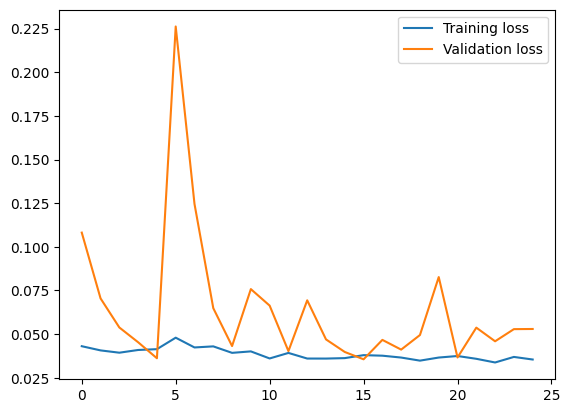

In [24]:
plt.plot(b , label="Training loss")
plt.plot(a , label="Validation loss")
plt.legend()
plt.show()

# END OF PHASE 1

**THe above part was completed in phase 1. Now in phase two we are trying to improve the model running more number of epoches**

# PHASE 2 work of Model 1 begins from here

In [25]:
model.fit(X_train,Y_train, validation_split=0.2, epochs=25)

Epoch 1/25
79/79 [==============================] - 40s 505ms/step - loss: 0.0359 - val_loss: 0.0550
Epoch 2/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0363 - val_loss: 0.3043
Epoch 3/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0393 - val_loss: 0.0696
Epoch 4/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0360 - val_loss: 0.0816
Epoch 5/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0356 - val_loss: 0.0530
Epoch 6/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0345 - val_loss: 0.0536
Epoch 7/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0335 - val_loss: 0.0783
Epoch 8/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0359 - val_loss: 0.0389
Epoch 9/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0333 - val_loss: 0.0393
Epoch 10/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0351 - val_lo

In [26]:
model.save_weights('model75.h5')

In [27]:
a = model.history.history['val_loss']
b = model.history.history['loss']
print(a)
print(b)

[0.05499335378408432, 0.30433428287506104, 0.06957711279392242, 0.08160776644945145, 0.05301474779844284, 0.05360276624560356, 0.07834228128194809, 0.03887966647744179, 0.03926071524620056, 0.036599453538656235, 0.09502246975898743, 0.034831371158361435, 0.032518867403268814, 0.033902786672115326, 0.08980654180049896, 0.03237611800432205, 0.046775851398706436, 0.0814555436372757, 0.03885810449719429, 0.050110671669244766, 0.03460415452718735, 0.05059787631034851, 0.04971648380160332, 0.04062967747449875, 0.03290144354104996]
[0.03586030751466751, 0.03634842485189438, 0.03931208327412605, 0.035962991416454315, 0.03562873974442482, 0.03451068326830864, 0.03345032408833504, 0.03587142005562782, 0.03331844508647919, 0.03510203957557678, 0.03506684675812721, 0.03498990833759308, 0.033936578780412674, 0.034099873155355453, 0.033738646656274796, 0.033364437520504, 0.03280193731188774, 0.03556174412369728, 0.03382308408617973, 0.03423314169049263, 0.03296350687742233, 0.03317229822278023, 0.03

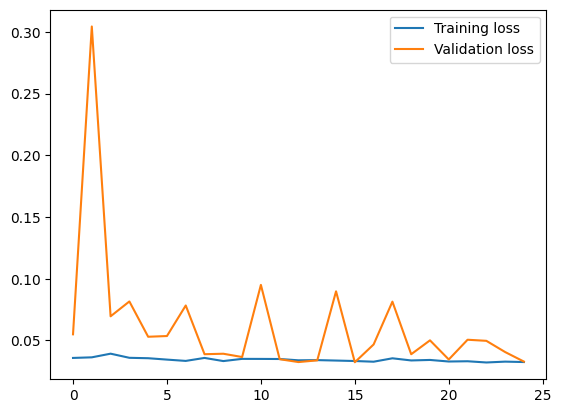

In [28]:
plt.plot(b , label="Training loss")
plt.plot(a , label="Validation loss")
plt.legend()
plt.show()

In [29]:
model.fit(X_train,Y_train, validation_split=0.2, epochs=25)

Epoch 1/25
79/79 [==============================] - 40s 505ms/step - loss: 0.0327 - val_loss: 0.0335
Epoch 2/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0315 - val_loss: 0.0456
Epoch 3/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0335 - val_loss: 0.0316
Epoch 4/25
79/79 [==============================] - 39s 494ms/step - loss: 0.0320 - val_loss: 0.0507
Epoch 5/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0315 - val_loss: 0.0327
Epoch 6/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0333 - val_loss: 0.0348
Epoch 7/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0309 - val_loss: 0.0335
Epoch 8/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0312 - val_loss: 0.0427
Epoch 9/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0318 - val_loss: 0.0400
Epoch 10/25
79/79 [==============================] - 39s 493ms/step - loss: 0.0315 - val_lo

In [30]:
model.save_weights('model100.h5')

In [31]:
a = model.history.history['val_loss']
b = model.history.history['loss']
print(a)
print(b)

[0.03349514305591583, 0.045637745410203934, 0.03162079676985741, 0.05072411149740219, 0.03272796422243118, 0.03481803461909294, 0.03350567817687988, 0.04269280657172203, 0.03997242450714111, 0.030067192390561104, 0.049855247139930725, 0.033975813537836075, 0.03227583318948746, 0.03783056139945984, 0.032230962067842484, 0.055559348315000534, 0.045911755412817, 0.03344319388270378, 0.046234458684921265, 0.04301055520772934, 0.06101659685373306, 0.03317767009139061, 0.034540094435214996, 0.030970053747296333, 0.04539760202169418]
[0.03265851363539696, 0.031453896313905716, 0.03345894068479538, 0.0319996178150177, 0.03150540590286255, 0.033313073217868805, 0.030895262956619263, 0.03119429014623165, 0.03181251883506775, 0.031532835215330124, 0.03243386372923851, 0.03080597147345543, 0.030744627118110657, 0.030428247526288033, 0.030936457216739655, 0.03221551328897476, 0.029782801866531372, 0.030772773548960686, 0.031702667474746704, 0.03043018840253353, 0.0300167053937912, 0.031693316996097

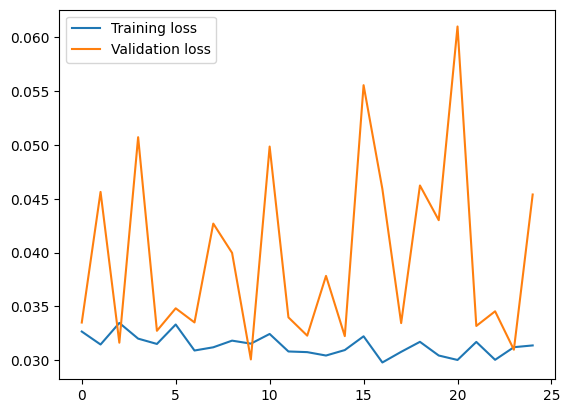

In [32]:
plt.plot(b , label="Training loss")
plt.plot(a , label="Validation loss")
plt.legend()
plt.show()

In [33]:
output_images = model.predict(X_test)

25/25 [==============================] - 4s 114ms/step


# Post processing

**Finding the inverse mask**

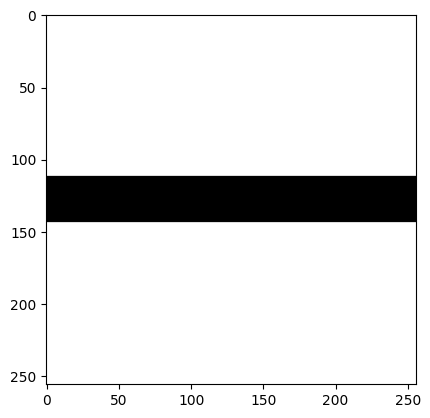

In [34]:
# Finding the inverse of mask
inv_mask = np.ones((256,256))
inv_mask[112:144,:] = np.zeros((32,256))
plt.imshow(inv_mask,cmap='gray')

* Multiply the inverse to the kspace obtained from the output image of model 
* Add this obtained result to the undersampled kspace to get the fully sampled kspace
* Inverse Fourier transform to convert data from frequency domain to image domain

This is the final output of the algorithm


In [35]:
recon_kspaces = []
recon_images = []
for i in range(len(output_images)):
    r_kspace = np.array(citf(output_images[i]))
    r_kspace = np.multiply(r_kspace , inv_mask)
    r_kspace = r_kspace + citf(X_test[i])
    recon_kspaces.append(r_kspace)
    recon_images.append(cfti(r_kspace))
recon_kspaces = np.asarray(recon_kspaces)
recon_images = np.asarray(recon_images)
    

# Visualizing the output from the model after preprocessing

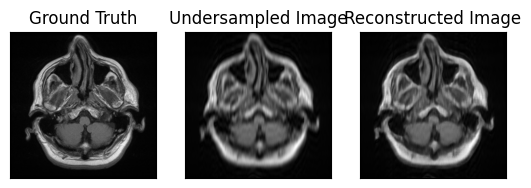

In [40]:
plt.subplot(131), plt.imshow(Y_test[10], cmap='gray')
plt.title('Ground Truth'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(X_test[10], cmap='gray')
plt.title('Undersampled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(recon_images[10], cmap='gray')
plt.title('Reconstructed Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Analysis of the Model

In [42]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(img1,img2):
    img_array1 = img1
    img_array2 = img2
    ssim_value, _ = ssim(img_array1, img_array2, full=True, multichannel=False , data_range=1.0)
    psnr_value = psnr(img_array1, img_array2)

    return ssim_value, psnr_value

avg_ssim_old = 0
avg_psnr_old = 0
avg_ssim_new = 0
avg_psnr_new = 0
for i in range(20):
    deblurred = recon_images[i]
    target = Y_test[i]
    blurred = X_test[i]
    ssim_result_old, psnr_result_old = calculate_metrics(target,blurred)
    ssim_result_new, psnr_result_new = calculate_metrics(target,deblurred)
    avg_ssim_old = avg_ssim_old + ssim_result_old
    avg_ssim_new = avg_ssim_new + ssim_result_new
    avg_psnr_old = avg_psnr_old + psnr_result_old
    avg_psnr_new = avg_psnr_new + psnr_result_new
avg_ssim_old=avg_ssim_old/20
avg_psnr_old=avg_psnr_old/20
avg_ssim_new=avg_ssim_new/20
avg_psnr_new=avg_psnr_new/20

print("RESULTS")
print("-"*25)
print("Avg SSIM between target and blurred image =",avg_ssim_new)
print("Avg SSIM between target and deblurred image =",avg_ssim_old)
print("-"*25)
print("Avg PSNR between target and blurred image =",avg_psnr_new)
print("Avg PSNR between target and deblurred image =",avg_psnr_old)

RESULTS
-------------------------
Avg SSIM between target and blurred image = 0.7734475678476569
Avg SSIM between target and deblurred image = 0.839262833766049
-------------------------
Avg PSNR between target and blurred image = 26.997193178883474
Avg PSNR between target and deblurred image = 29.871343676221052


/tmp/ipykernel_47/116410607.py:10: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(img_array1, img_array2)


# END OF MODEL 1